# Shallow Bayesian predictive coding networks

Here we invesigate Bayesian sparse predictive coding networks consisting only of a single "hidden" layer. We will extend the standard PCN appraoch to a full Bayesian treatment of sparse PCNs. Unlike sparse PCNs where inference and learning relies on MAP estimates for latent variables and MLE estimate for weights, we will formulate Bayesian sparse PCNs with defined prior over weights and the full estimate of the posterior of latent variables and weights.

The investigation is inspired by the following paper: "Illing, Bernd, Wulfram Gerstner, and Johanni Brea. "Biologically plausible deep learning—but how far can we go with shallow networks?." Neural Networks 118 (2019): 90-101". The authors were interested to understand the limitations of shallow networks for image classification, with the aim to test local biologically plaussible learning rules. PCNs result in learning rules that are local and hebbian like, and no backpropagation beween layers is necessary, hence one naturally obtains biologically plaussible learning.  

Here we will utilise the same paradigm of shallow networks, to test how Bayesian treatment of sparse PCNs changes the performance of classification algorithms. 

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [16]:
import jax.numpy as jnp
from jax import random
from jax.nn import one_hot, softmax
from flax import linen as fnn
from typing import Any, Callable, Sequence
import matplotlib.pyplot as plt

Shallow neural network

In [3]:
class DenseNet(fnn.Module):
  """A simple dense neural network."""

  features: Sequence[int]
  act: Callable

  @fnn.compact
  def __call__(self, x, **kwargs):
    x = fnn.Dense(features=self.features[0], name='dense0')(x)
    for i, f in enumerate(self.features[1:]):
        x = self.act(x)
        x = fnn.Dense(features=f, name='dense{}'.format(i+1))(x)
    
    return x

ShallowNet = lambda n, c: DenseNet([n, c], fnn.relu)

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.module import flax_module

def likelihood(nnet, images, labels, n, subsample_size):
    with numpyro.plate("N", n, subsample_size=subsample_size):
        batch_x = numpyro.subsample(images, event_dim=1)
        pred = nnet(batch_x)
        
        if labels is not None:
            batch_y = numpyro.subsample(labels, event_dim=0)
        else:
            batch_y = None
        
        logits = jnp.pad(pred, ((0, 0), (0, 1)))
        numpyro.deterministic('probs', softmax(logits, -1))
        numpyro.sample(
            "obs", dist.Categorical(logits=logits), obs=batch_y
        )
            
def shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    n, d = images.shape

    nnet = flax_module("nnet", ShallowNet(n_neurons, n_labels - 1), input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [5]:
import optax
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, TraceMeanField_ELBO, Predictive, log_likelihood

def test_smpl(model, sample, images, labels, n_neurons):

    probs = sample['probs'].mean(0)
    pred_labels = probs.argmax(-1)

    hit = pred_labels == labels
    acc = hit.mean(-1)

    return {
        'acc': acc,
    }


def fitting_and_testing(model, train_ds, test_ds, rng_key, number_of_hidden_neurons, n_iter=10000, num_samples=1):
    guide = lambda *args, **kwargs: None  # MLE estimate
    opt = optax.chain(
        optax.clip_by_global_norm(1e2),
        optax.adabelief(1e-4)
    )
    optimizer = numpyro.optim.optax_to_numpyro(opt)

    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    #########################################

    rng_key, _rng_key = random.split(rng_key)

    svi_result = svi.run(
        _rng_key, 
        n_iter, 
        train_ds['image'],
        n_neurons=number_of_hidden_neurons, 
        labels=train_ds['label'], 
        subsample_size=512)

    params = svi_result.params

    pred = Predictive(model, params={**params}, num_samples=num_samples)
    rng_key, _rng_key = random.split(rng_key)
    sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)

    out = test_smpl(model, sample, test_ds['image'], test_ds['label'], number_of_hidden_neurons)
    
    print(f'acc: ', out['acc'])
    
    return out

In [6]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')

train_ds['image'] = train_ds['image'].reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].reshape(test_ds['image'].shape[0], -1)

n, d = train_ds['image'].shape

cov_matrix = jnp.cov(train_ds['image'].T)
eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)

W_pca = eigen_vectors / jnp.sqrt(eigen_values + 1/n)
W_zca = W_pca @ eigen_vectors.T

mean = train_ds['image'].mean(0)
train_ds['image'] = (train_ds['image'] - mean) @ W_zca + mean

mean = test_ds['image'].mean(0)
test_ds['image'] = (test_ds['image'] - mean) @ W_zca + mean

In [7]:
num_hn = [40, 80, 160, 320, 640]

In [8]:
rng_key = random.PRNGKey(1001)

res = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    res.append(fitting_and_testing(shallownet, train_ds, test_ds, _rng_key, n_neurons, n_iter=100_000))

100%|██████████| 100000/100000 [01:19<00:00, 1251.03it/s, init loss: 149462.3438, avg. loss [95001-100000]: 284.5976]


acc:  0.811


100%|██████████| 100000/100000 [01:19<00:00, 1252.35it/s, init loss: 153400.7188, avg. loss [95001-100000]: 0.0165] 


acc:  0.8236


100%|██████████| 100000/100000 [01:19<00:00, 1251.01it/s, init loss: 147466.9688, avg. loss [95001-100000]: 0.0000] 


acc:  0.8397


100%|██████████| 100000/100000 [01:22<00:00, 1206.15it/s, init loss: 149595.7500, avg. loss [95001-100000]: 0.0000]


acc:  0.85639995


100%|██████████| 100000/100000 [01:23<00:00, 1203.20it/s, init loss: 151184.6406, avg. loss [95001-100000]: 2.2418]


acc:  0.8667


## Bayesian shallow neural network

In [9]:
from numpyro.contrib.module import random_flax_module

def bayes_shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    n, d = images.shape
    
    prior = {"dense0.bias": dist.Cauchy(), 
             "dense0.kernel": dist.Normal(0., 1.),
             "dense1.bias":dist.Cauchy(),
             "dense1.kernel": dist.Normal(0., 1.)
            }
    nnet = random_flax_module('nnet', ShallowNet(n_neurons, n_labels - 1), prior, input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [10]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from jax import device_put, devices

def bayes_fitting_and_testing(
    model, 
    train_ds, 
    test_ds, 
    rng_key, 
    number_of_hidden_neurons, 
    n_iter=10000, 
    approx='delta'
):
    if approx == 'mean-field':
        guide = AutoNormal(model) # Mean-field
    else:
        guide = AutoDelta(model)  # MAP

    opt = optax.chain(
        optax.clip_by_global_norm(1e2),
        optax.adabelief(1e-3)
    )
    optimizer = numpyro.optim.optax_to_numpyro(opt)
    if approx == 'mean-field':
        svi = SVI(model, guide, optimizer, loss=TraceGraph_ELBO(num_particles=10))
    else:
        svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO(num_particles=1))
    #########################################

    rng_key, _rng_key = random.split(rng_key)

    svi_result = svi.run(
        _rng_key, 
        n_iter, 
        train_ds['image'],
        n_neurons=number_of_hidden_neurons, 
        labels=train_ds['label'], 
        subsample_size=512)

    params = svi_result.params
    params = device_put(params, devices('cpu')[0])  
    
    if approx == 'delta':
        pred = Predictive(model, guide=guide, params={**params}, num_samples=1)
        rng_key, _rng_key = random.split(rng_key)
        sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)

        out = test_smpl(model, sample, test_ds['image'], test_ds['label'], number_of_hidden_neurons)

    else:
        pred = Predictive(model, guide=guide, params={**params}, num_samples=100)
        rng_key, _rng_key = random.split(rng_key)
        sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)

        out = test_smpl(model, sample, test_ds['image'], test_ds['label'], number_of_hidden_neurons)
        
    print(f'acc: ', out['acc'])
    
    return out

In [11]:
rng_key = random.PRNGKey(102301)

num_hn = [40, 80, 160, 320, 640]
map_res = []
bayes_res = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    map_res.append(
        bayes_fitting_and_testing(bayes_shallownet, train_ds, test_ds, _rng_key, n_neurons, n_iter=200_000)
    )

    bayes_res.append(
        bayes_fitting_and_testing(
            bayes_shallownet, 
            train_ds, 
            test_ds, 
            _rng_key, 
            n_neurons, 
            n_iter=400_000, 
            approx='mean-field'
        )
    )

2023-03-03 15:55:29.326486: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-03-03 15:55:29.342906: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
100%|██████████| 200000/200000 [02:41<00:00, 1234.59it/s, init loss: 980107.5625, avg. loss [190001-200000]: 30001.1250]


acc:  0.8012


100%|██████████| 400000/400000 [13:42<00:00, 486.23it/s, init loss: 14200343.0000, avg. loss [380001-400000]: 32982.2031]


acc:  0.8469


2023-03-03 16:13:29.070937: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
100%|██████████| 200000/200000 [02:51<00:00, 1162.83it/s, init loss: 1696117.2500, avg. loss [190001-200000]: 58839.6445]


acc:  0.8461


100%|██████████| 400000/400000 [14:26<00:00, 461.84it/s, init loss: 18141826.0000, avg. loss [380001-400000]: 34451.9453]


acc:  0.8484


2023-03-03 16:32:26.623330: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
100%|██████████| 200000/200000 [02:55<00:00, 1140.67it/s, init loss: 2247919.5000, avg. loss [190001-200000]: 117241.3516]


acc:  0.8627


100%|██████████| 400000/400000 [17:25<00:00, 382.62it/s, init loss: 27471862.0000, avg. loss [380001-400000]: 37463.9688]


acc:  0.8552


2023-03-03 16:54:25.295821: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
100%|██████████| 200000/200000 [02:52<00:00, 1160.06it/s, init loss: 3792399.5000, avg. loss [190001-200000]: 234028.7031]


acc:  0.86399996


100%|██████████| 400000/400000 [21:42<00:00, 307.08it/s, init loss: 37001152.0000, avg. loss [380001-400000]: 44480.2461] 


acc:  0.8527


2023-03-03 17:20:35.312481: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
100%|██████████| 200000/200000 [03:19<00:00, 1003.79it/s, init loss: 4283944.0000, avg. loss [190001-200000]: 467570.9062]


acc:  0.8645


  0%|          | 0/400000 [00:00<?, ?it/s]2023-03-03 17:24:39.048396: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.1683 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-03 17:24:39.273106: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.22513348s
Constant folding an instruction is taking > 1s:

  reduce.1683 (displaying the full instruction incurs a runtime overhead. Raise you

acc:  0.8451


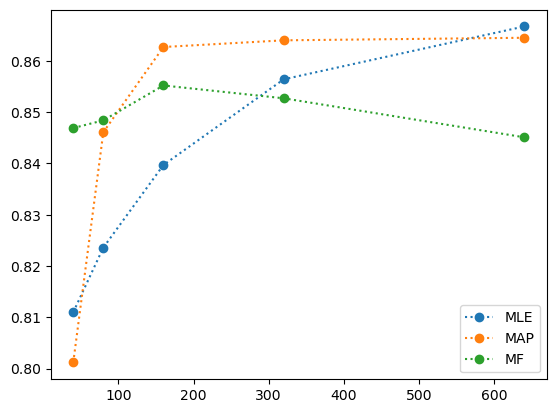

In [18]:
plt.plot(num_hn, [r['acc'] for r in res], 'o:', label='MLE');
plt.plot(num_hn, [r['acc'] for r in map_res], 'o:', label='MAP');
plt.plot(num_hn, [r['acc'] for r in bayes_res], 'o:', label='MF');

plt.legend()

## Sparse Bayesian shallow neural network

In [ ]:
def sparse_bayes_shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    '''Generative model based on the following paper
    Ghosh, Soumya, and Finale Doshi-Velez. 
    "Model selection in Bayesian neural networks via horseshoe priors." 
    arXiv preprint arXiv:1705.10388 (2017).
    '''
    n, d = images.shape
    
    bar_t0 = numpyro.sample('bar_t0', dist.InverseGamma(1/2, 1.))
    til_t0 = numpyro.sample('til_t0', dist.InverseGamma(1/2, 1.))
    tau0 = numpyro.deterministic('tau0', til_t0/bar_t0)
    
    bar_l0 = numpyro.sample('bar_l0', dist.InverseGamma(1/2, 1.).expand([n_neurons]).to_event(1))
    til_l0 = numpyro.sample('til_l0', dist.InverseGamma(1/2, 1.).expand([n_neurons]).to_event(1))
    lam0 = numpyro.deterministic('lam0', til_l0/bar_l0)
    
    b_1 = 5.
    bar_l1 = numpyro.sample('bar_l1', dist.InverseGamma(1/2, 1.).expand([n_labels]).to_event(1))
    til_l1 = numpyro.sample('til_l1', dist.InverseGamma(1/2, 1.).expand([n_labels]).to_event(1))
    lam1 = numpyro.deterministic('lam1', b_1**2 * til_l1 / bar_l1)
    
    prior = {"dense0.bias": dist.Cauchy(), 
             "dense0.kernel": dist.Normal(0., lam0 * tau0),
             "dense1.bias": dist.Cauchy(),
             "dense1.kernel": dist.Normal(0., lam1)
            }
    nnet = random_flax_module('nnet', ShallowNet(n_neurons, n_labels), prior, input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [ ]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "nnet/dense0.kernel": LocScaleReparam(0),
    "nnet/dense1.kernel": LocScaleReparam(0),
}
reparam_model = reparam(
    sparse_bayes_shallownet, config=reparam_config
)

In [ ]:
rng_key = random.PRNGKey(10234501)

sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000)
    )

100%|████████████████████████████████████| 20000/20000 [00:28<00:00, 706.58it/s, init loss: 6788181.5000, avg. loss [19001-20000]: 19180.7305]


model acc : 0.9066


100%|███████████████████████████████████| 20000/20000 [00:28<00:00, 693.54it/s, init loss: 27533396.0000, avg. loss [19001-20000]: 21490.5234]


model acc : 0.9402


100%|███████████████████████████████████| 20000/20000 [00:28<00:00, 692.37it/s, init loss: 17412846.0000, avg. loss [19001-20000]: 32853.9805]


model acc : 0.95769995


100%|██████████████████████████████████| 20000/20000 [00:28<00:00, 697.69it/s, init loss: 349221536.0000, avg. loss [19001-20000]: 60702.5742]


model acc : 0.9659


100%|█████████████████████████████████| 20000/20000 [00:28<00:00, 690.62it/s, init loss: 107993264.0000, avg. loss [19001-20000]: 120244.8906]


model acc : 0.9715


100%|█████████████████████████████████| 20000/20000 [00:29<00:00, 680.33it/s, init loss: 175932896.0000, avg. loss [19001-20000]: 238960.7656]


model acc : 0.97249997


100%|████████████████████████████████| 20000/20000 [00:30<00:00, 645.47it/s, init loss: 5619810304.0000, avg. loss [19001-20000]: 477615.9375]


model acc : 0.9748


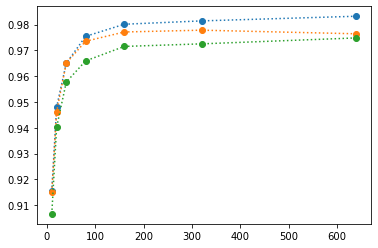

In [ ]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');
plt.plot(num_hn, sparse_accs, 'o:');

In [ ]:
rng_key = random.PRNGKey(102348221)
sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000, approx='mean-field')
    )

100%|█████████████████████████████████| 20000/20000 [00:44<00:00, 449.69it/s, init loss: 6329416192.0000, avg. loss [19001-20000]: 23661.5938]


model acc : 0.9194


100%|██████████████████████████████████| 20000/20000 [00:44<00:00, 447.38it/s, init loss: 855923520.0000, avg. loss [19001-20000]: 20282.6289]


model acc : 0.94909996


100%|██████████████████████████████████| 20000/20000 [00:44<00:00, 447.32it/s, init loss: 474137024.0000, avg. loss [19001-20000]: 22101.1738]


model acc : 0.96459997


100%|█████████████████████████████████| 20000/20000 [00:46<00:00, 432.80it/s, init loss: 3717707776.0000, avg. loss [19001-20000]: 66037.8438]


model acc : 0.959


100%|█████████████████████████████████| 20000/20000 [00:48<00:00, 413.54it/s, init loss: 437753216.0000, avg. loss [19001-20000]: 399303.5938]


model acc : 0.9536


100%|███████████████████████████████| 20000/20000 [00:46<00:00, 426.38it/s, init loss: 12485942272.0000, avg. loss [19001-20000]: 572157.0625]


model acc : 0.9636


100%|████████████████████████████████| 20000/20000 [00:48<00:00, 414.85it/s, init loss: 7574020096.0000, avg. loss [19001-20000]: 300416.7812]


model acc : 0.9748
